## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [35]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    # Valid means no padding and drops the rightmost columns, or bottom-most rows
    # SAME tries to pad evenly left and right, but if the amount of columns to be
    # added is odd, it will add the extra column to the right.
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 7.97 and accuracy of 0.062
Iteration 100: with minibatch training loss = 0.863 and accuracy of 0.33
Iteration 200: with minibatch training loss = 0.665 and accuracy of 0.28
Iteration 300: with minibatch training loss = 0.714 and accuracy of 0.31
Iteration 400: with minibatch training loss = 0.703 and accuracy of 0.28
Iteration 500: with minibatch training loss = 0.553 and accuracy of 0.3
Iteration 600: with minibatch training loss = 0.483 and accuracy of 0.28
Iteration 700: with minibatch training loss = 0.486 and accuracy of 0.38
Epoch 1, Overall loss = 0.737 and accuracy of 0.308


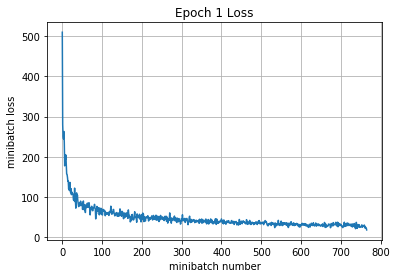

Validation
Epoch 1, Overall loss = 0.433 and accuracy of 0.333


In [38]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        
        # (zy) shuffle indicies every epoch 
        train_indicies = np.arange(Xd.shape[0])
        np.random.shuffle(train_indicies)
        
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [39]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    W1 = tf.get_variable("W1", shape=[7, 7, 3, 32])
    b1 = tf.get_variable("b1", shape=[32])
    W2 = tf.get_variable("W2", shape=[5408, 1024])
    b2 = tf.get_variable("b2", shape=[1024])
    W3 = tf.get_variable("W3", shape=[1024, 10])
    b3 = tf.get_variable("b3", shape=[10])

    out = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="VALID") + b1
    out = tf.nn.relu(out)
    out = tf.layers.batch_normalization(inputs=out, training=is_training)
    out = tf.nn.max_pool(out, (1, 2, 2, 1),  (1, 2, 2, 1), "VALID")
    # can also use tf.contrib.layers.fully_connected(...)
    out = tf.reshape(out, [-1, 5408])
    out = tf.matmul(out, W2) + b2
    out = tf.nn.relu(out)
    y_out = tf.matmul(out, W3) + b3
    
    return y_out

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [40]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

1.52 ms ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [41]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

1.54 ms ± 40.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [42]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!

# Labels used in softmax_cross_entropy_with_logits are the one hot version of labels
# used in sparse_softmax_cross_entropy_with_logits
total_loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.RMSPropOptimizer(1e-3)

In [43]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [44]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.12 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.58 and accuracy of 0.33
Iteration 200: with minibatch training loss = 1.81 and accuracy of 0.33
Iteration 300: with minibatch training loss = 1.7 and accuracy of 0.47
Iteration 400: with minibatch training loss = 1.39 and accuracy of 0.5
Iteration 500: with minibatch training loss = 1.31 and accuracy of 0.48
Iteration 600: with minibatch training loss = 1.6 and accuracy of 0.39
Iteration 700: with minibatch training loss = 1.66 and accuracy of 0.52
Epoch 1, Overall loss = 1.67 and accuracy of 0.451


(1.669103802778283, 0.45148979591836735)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [45]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.32 and accuracy of 0.562


(1.3166498651504517, 0.562)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [57]:
# Feel free to play with this cell
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define my own model
# Not using fully connected layers
# Not using pooling but stride size/down-sampling
# Not using weight decay/dropout but with batch normalization (if permitted
# more data augmentation will be better)
def my_model(X,y,is_training):  
    bn1 = tf.layers.batch_normalization(inputs=X, training=is_training)
    relu1 = tf.nn.elu(bn1)
    conv1 = tf.layers.conv2d(inputs=relu1, filters=128, kernel_size=[2, 2],
                             strides=(1, 1), padding="valid") # 31*31*64
    bn2 = tf.layers.batch_normalization(inputs=conv1, training=is_training)
    relu2 = tf.nn.elu(bn2)
    conv2 = tf.layers.conv2d(inputs=relu2, filters=64, kernel_size=[4, 4],
                             strides=(2, 2), padding="valid") # 14*14*32
    bn3 = tf.layers.batch_normalization(inputs=conv2, training=is_training)
    relu3 = tf.nn.elu(bn3)
    conv3 = tf.layers.conv2d(inputs=relu3, filters=32, kernel_size=[5, 5],
                             strides=(2, 2), padding="valid") # 5*5*32
    bn4 = tf.layers.batch_normalization(inputs=conv3, training=is_training)
    relu4 = tf.nn.elu(bn4)
    conv4 = tf.layers.conv2d(inputs=bn4, filters=10, kernel_size=[5, 5],
                             strides=(1, 1), padding="valid") # 1*1*10
    y_out = tf.reshape(conv4, (-1, 10))
    
    return y_out

y_out = my_model(X,y,is_training)

total_loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# use learning rate decay
# tf.Variable is low-level way to initiate a pure variable (Variable is a class, here we talk about ~.__init__).
# tf.get_variable does the same thing, but also makes it easier to refactor the codes if we want to share
# variables at any time
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 3e-5
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 10000, 0.7, staircase=True)

# See tf.train.exponential_decay documentation for reference
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss, global_step=global_step)

Training
Iteration 0: with minibatch training loss = 3.09 and accuracy of 0.12
Iteration 200: with minibatch training loss = 1.72 and accuracy of 0.39
Iteration 400: with minibatch training loss = 1.91 and accuracy of 0.28
Iteration 600: with minibatch training loss = 1.63 and accuracy of 0.36
Epoch 1, Overall loss = 1.9 and accuracy of 0.328


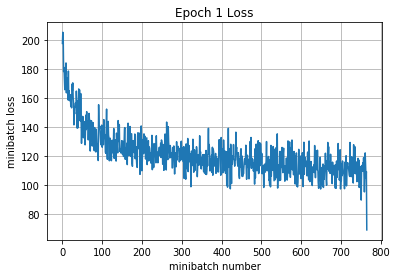

Iteration 800: with minibatch training loss = 1.53 and accuracy of 0.41
Iteration 1000: with minibatch training loss = 1.59 and accuracy of 0.47
Iteration 1200: with minibatch training loss = 1.69 and accuracy of 0.44
Iteration 1400: with minibatch training loss = 1.51 and accuracy of 0.47
Epoch 2, Overall loss = 1.62 and accuracy of 0.424


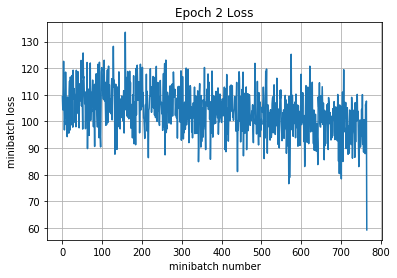

Iteration 1600: with minibatch training loss = 1.77 and accuracy of 0.39
Iteration 1800: with minibatch training loss = 1.39 and accuracy of 0.52
Iteration 2000: with minibatch training loss = 1.42 and accuracy of 0.39
Iteration 2200: with minibatch training loss = 1.39 and accuracy of 0.48
Epoch 3, Overall loss = 1.5 and accuracy of 0.467


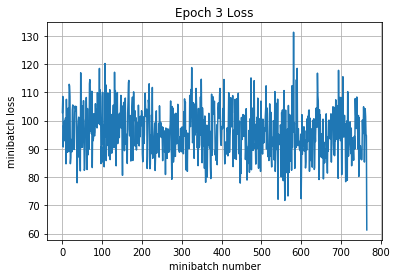

Iteration 2400: with minibatch training loss = 1.35 and accuracy of 0.55
Iteration 2600: with minibatch training loss = 1.6 and accuracy of 0.42
Iteration 2800: with minibatch training loss = 1.29 and accuracy of 0.55
Iteration 3000: with minibatch training loss = 1.32 and accuracy of 0.53
Epoch 4, Overall loss = 1.43 and accuracy of 0.493


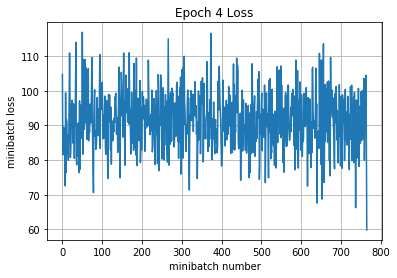

Iteration 3200: with minibatch training loss = 1.33 and accuracy of 0.55
Iteration 3400: with minibatch training loss = 1.32 and accuracy of 0.59
Iteration 3600: with minibatch training loss = 1.24 and accuracy of 0.48
Iteration 3800: with minibatch training loss = 1.35 and accuracy of 0.52
Epoch 5, Overall loss = 1.38 and accuracy of 0.512


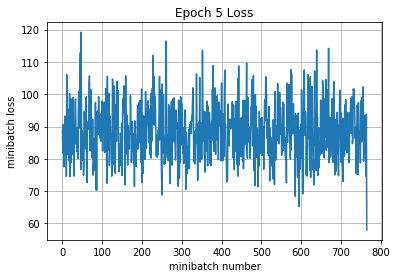

Iteration 4000: with minibatch training loss = 1.44 and accuracy of 0.45
Iteration 4200: with minibatch training loss = 1.58 and accuracy of 0.42
Iteration 4400: with minibatch training loss = 1.27 and accuracy of 0.48
Epoch 6, Overall loss = 1.35 and accuracy of 0.526


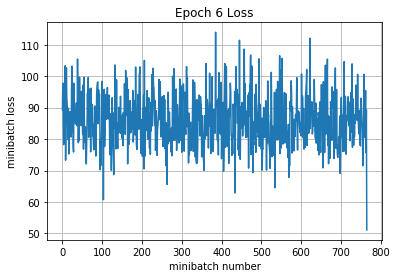

Iteration 4600: with minibatch training loss = 1.28 and accuracy of 0.59
Iteration 4800: with minibatch training loss = 1.16 and accuracy of 0.66
Iteration 5000: with minibatch training loss = 1.4 and accuracy of 0.5
Iteration 5200: with minibatch training loss = 1.18 and accuracy of 0.55
Epoch 7, Overall loss = 1.31 and accuracy of 0.536


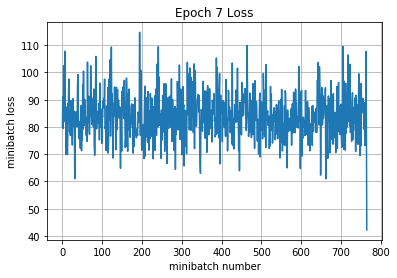

Iteration 5400: with minibatch training loss = 1.16 and accuracy of 0.58
Iteration 5600: with minibatch training loss = 1.35 and accuracy of 0.5
Iteration 5800: with minibatch training loss = 1.47 and accuracy of 0.48
Iteration 6000: with minibatch training loss = 1.33 and accuracy of 0.53
Epoch 8, Overall loss = 1.28 and accuracy of 0.548


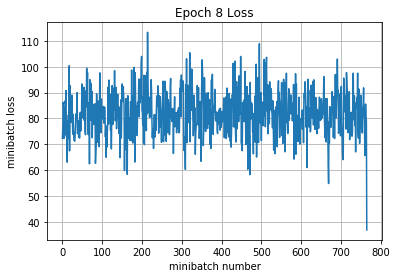

Iteration 6200: with minibatch training loss = 1.23 and accuracy of 0.61
Iteration 6400: with minibatch training loss = 1.13 and accuracy of 0.62
Iteration 6600: with minibatch training loss = 1.33 and accuracy of 0.58
Iteration 6800: with minibatch training loss = 1.49 and accuracy of 0.47
Epoch 9, Overall loss = 1.26 and accuracy of 0.56


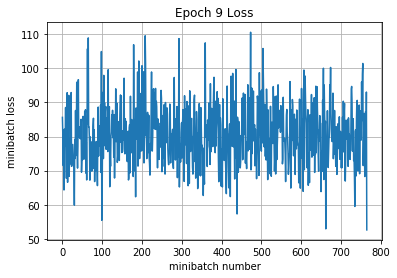

Iteration 7000: with minibatch training loss = 1.2 and accuracy of 0.56
Iteration 7200: with minibatch training loss = 1.11 and accuracy of 0.59
Iteration 7400: with minibatch training loss = 1.37 and accuracy of 0.56
Iteration 7600: with minibatch training loss = 1.09 and accuracy of 0.72
Epoch 10, Overall loss = 1.23 and accuracy of 0.568


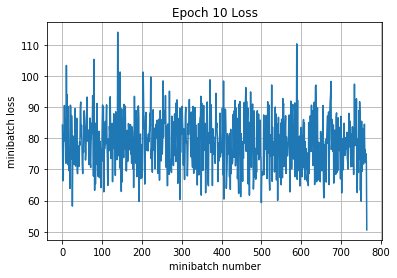

Iteration 7800: with minibatch training loss = 1.39 and accuracy of 0.5
Iteration 8000: with minibatch training loss = 1.02 and accuracy of 0.62
Iteration 8200: with minibatch training loss = 1.07 and accuracy of 0.59
Iteration 8400: with minibatch training loss = 1.4 and accuracy of 0.5
Epoch 11, Overall loss = 1.21 and accuracy of 0.578


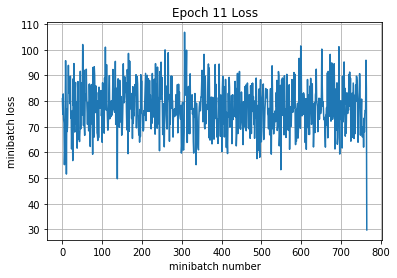

Iteration 8600: with minibatch training loss = 1.15 and accuracy of 0.64
Iteration 8800: with minibatch training loss = 1.32 and accuracy of 0.45
Iteration 9000: with minibatch training loss = 1.26 and accuracy of 0.58
Epoch 12, Overall loss = 1.19 and accuracy of 0.585


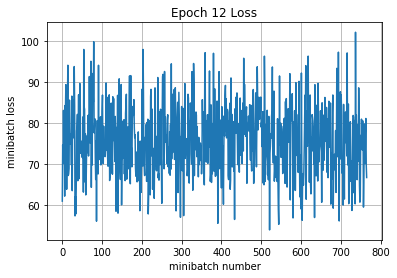

Iteration 9200: with minibatch training loss = 1.01 and accuracy of 0.66
Iteration 9400: with minibatch training loss = 1.49 and accuracy of 0.52
Iteration 9600: with minibatch training loss = 0.911 and accuracy of 0.64
Iteration 9800: with minibatch training loss = 1.47 and accuracy of 0.48
Epoch 13, Overall loss = 1.17 and accuracy of 0.591


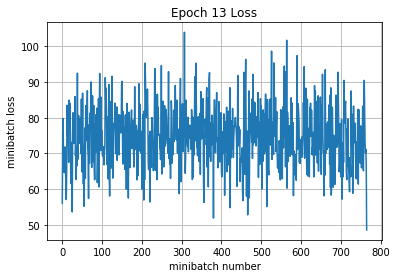

Iteration 10000: with minibatch training loss = 1.08 and accuracy of 0.53
Iteration 10200: with minibatch training loss = 1.18 and accuracy of 0.58
Iteration 10400: with minibatch training loss = 0.979 and accuracy of 0.66
Iteration 10600: with minibatch training loss = 1.31 and accuracy of 0.48
Epoch 14, Overall loss = 1.14 and accuracy of 0.603


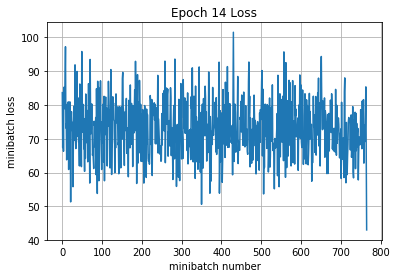

Iteration 10800: with minibatch training loss = 1.29 and accuracy of 0.55
Iteration 11000: with minibatch training loss = 0.939 and accuracy of 0.72
Iteration 11200: with minibatch training loss = 1.13 and accuracy of 0.62
Iteration 11400: with minibatch training loss = 0.966 and accuracy of 0.73
Epoch 15, Overall loss = 1.12 and accuracy of 0.608


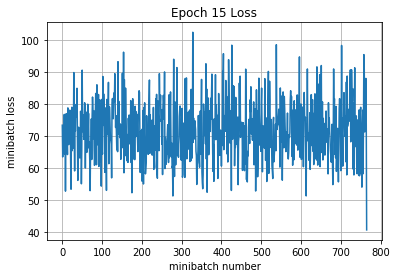

Iteration 11600: with minibatch training loss = 0.89 and accuracy of 0.7
Iteration 11800: with minibatch training loss = 1.26 and accuracy of 0.58
Iteration 12000: with minibatch training loss = 1.36 and accuracy of 0.53
Iteration 12200: with minibatch training loss = 0.866 and accuracy of 0.69
Epoch 16, Overall loss = 1.11 and accuracy of 0.612


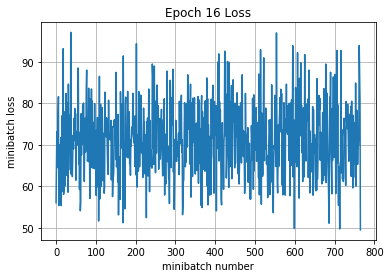

Iteration 12400: with minibatch training loss = 0.903 and accuracy of 0.77
Iteration 12600: with minibatch training loss = 1.29 and accuracy of 0.61
Iteration 12800: with minibatch training loss = 1.09 and accuracy of 0.64
Iteration 13000: with minibatch training loss = 1.16 and accuracy of 0.67
Epoch 17, Overall loss = 1.1 and accuracy of 0.615


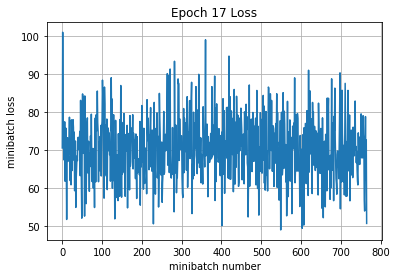

Iteration 13200: with minibatch training loss = 1.17 and accuracy of 0.55
Iteration 13400: with minibatch training loss = 1.16 and accuracy of 0.58
Iteration 13600: with minibatch training loss = 0.876 and accuracy of 0.72
Epoch 18, Overall loss = 1.09 and accuracy of 0.621


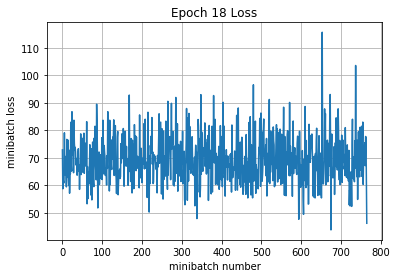

Iteration 13800: with minibatch training loss = 1.01 and accuracy of 0.66
Iteration 14000: with minibatch training loss = 1.12 and accuracy of 0.62
Iteration 14200: with minibatch training loss = 1.11 and accuracy of 0.59
Iteration 14400: with minibatch training loss = 1.08 and accuracy of 0.61
Epoch 19, Overall loss = 1.07 and accuracy of 0.626


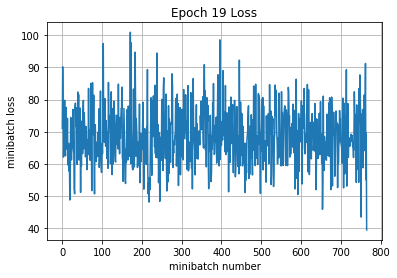

Iteration 14600: with minibatch training loss = 0.812 and accuracy of 0.73
Iteration 14800: with minibatch training loss = 1.08 and accuracy of 0.66
Iteration 15000: with minibatch training loss = 1.22 and accuracy of 0.53
Iteration 15200: with minibatch training loss = 0.993 and accuracy of 0.66
Epoch 20, Overall loss = 1.07 and accuracy of 0.63


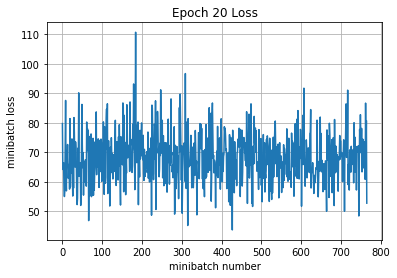

Iteration 15400: with minibatch training loss = 0.955 and accuracy of 0.7
Iteration 15600: with minibatch training loss = 0.953 and accuracy of 0.67
Iteration 15800: with minibatch training loss = 0.865 and accuracy of 0.7
Iteration 16000: with minibatch training loss = 1 and accuracy of 0.66
Epoch 21, Overall loss = 1.05 and accuracy of 0.634


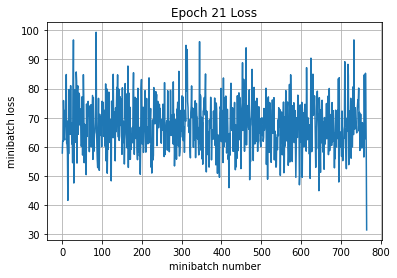

Iteration 16200: with minibatch training loss = 1.18 and accuracy of 0.66
Iteration 16400: with minibatch training loss = 1.02 and accuracy of 0.75
Iteration 16600: with minibatch training loss = 0.908 and accuracy of 0.64
Iteration 16800: with minibatch training loss = 0.898 and accuracy of 0.77
Epoch 22, Overall loss = 1.04 and accuracy of 0.637


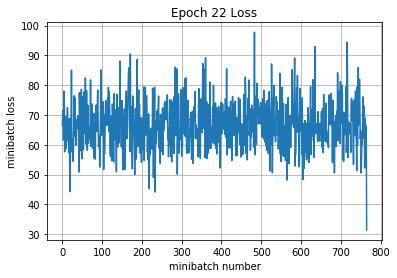

Iteration 17000: with minibatch training loss = 1.05 and accuracy of 0.61
Iteration 17200: with minibatch training loss = 0.788 and accuracy of 0.73
Iteration 17400: with minibatch training loss = 1.19 and accuracy of 0.55
Iteration 17600: with minibatch training loss = 1.12 and accuracy of 0.69
Epoch 23, Overall loss = 1.03 and accuracy of 0.64


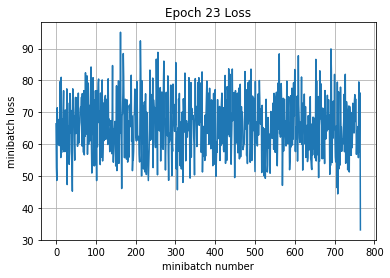

Iteration 17800: with minibatch training loss = 1.06 and accuracy of 0.61
Iteration 18000: with minibatch training loss = 1.13 and accuracy of 0.69
Iteration 18200: with minibatch training loss = 0.874 and accuracy of 0.7
Epoch 24, Overall loss = 1.02 and accuracy of 0.645


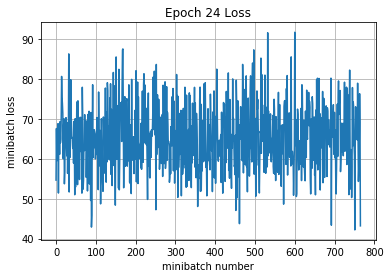

Iteration 18400: with minibatch training loss = 1.13 and accuracy of 0.58
Iteration 18600: with minibatch training loss = 0.991 and accuracy of 0.7
Iteration 18800: with minibatch training loss = 0.974 and accuracy of 0.62
Iteration 19000: with minibatch training loss = 1.11 and accuracy of 0.62
Epoch 25, Overall loss = 1.01 and accuracy of 0.648


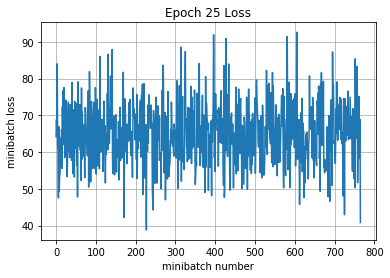

Iteration 19200: with minibatch training loss = 0.899 and accuracy of 0.64
Iteration 19400: with minibatch training loss = 1.2 and accuracy of 0.58
Iteration 19600: with minibatch training loss = 0.916 and accuracy of 0.66
Iteration 19800: with minibatch training loss = 1.07 and accuracy of 0.62
Epoch 26, Overall loss = 1.01 and accuracy of 0.651


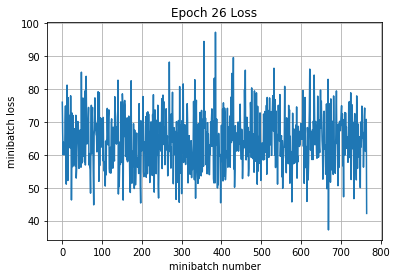

Iteration 20000: with minibatch training loss = 1.12 and accuracy of 0.56
Iteration 20200: with minibatch training loss = 0.807 and accuracy of 0.73
Iteration 20400: with minibatch training loss = 1.06 and accuracy of 0.58
Iteration 20600: with minibatch training loss = 0.921 and accuracy of 0.7
Epoch 27, Overall loss = 0.989 and accuracy of 0.658


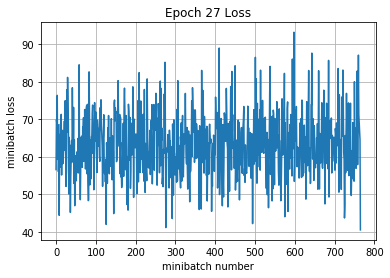

Iteration 20800: with minibatch training loss = 0.943 and accuracy of 0.66
Iteration 21000: with minibatch training loss = 1.03 and accuracy of 0.62
Iteration 21200: with minibatch training loss = 1.15 and accuracy of 0.66
Iteration 21400: with minibatch training loss = 0.838 and accuracy of 0.75
Epoch 28, Overall loss = 0.981 and accuracy of 0.661


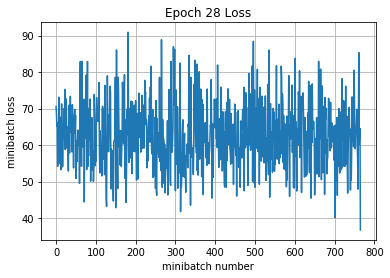

Iteration 21600: with minibatch training loss = 0.885 and accuracy of 0.72
Iteration 21800: with minibatch training loss = 1.11 and accuracy of 0.61
Iteration 22000: with minibatch training loss = 0.983 and accuracy of 0.69
Iteration 22200: with minibatch training loss = 0.787 and accuracy of 0.73
Epoch 29, Overall loss = 0.973 and accuracy of 0.664


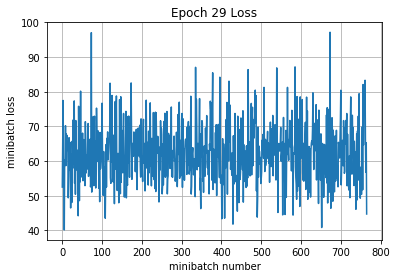

Iteration 22400: with minibatch training loss = 0.771 and accuracy of 0.75
Iteration 22600: with minibatch training loss = 0.733 and accuracy of 0.8
Iteration 22800: with minibatch training loss = 0.943 and accuracy of 0.69
Epoch 30, Overall loss = 0.969 and accuracy of 0.663


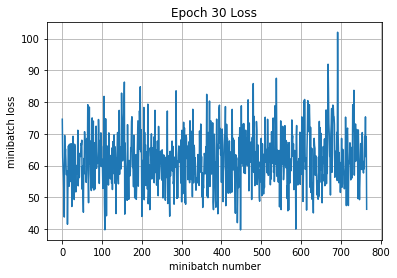

Iteration 23000: with minibatch training loss = 1.13 and accuracy of 0.61
Iteration 23200: with minibatch training loss = 1.06 and accuracy of 0.7
Iteration 23400: with minibatch training loss = 1.06 and accuracy of 0.66
Iteration 23600: with minibatch training loss = 1.05 and accuracy of 0.66
Epoch 31, Overall loss = 0.961 and accuracy of 0.668


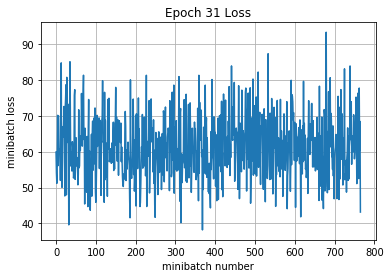

Iteration 23800: with minibatch training loss = 0.764 and accuracy of 0.69
Iteration 24000: with minibatch training loss = 0.959 and accuracy of 0.67
Iteration 24200: with minibatch training loss = 1 and accuracy of 0.69
Iteration 24400: with minibatch training loss = 1.15 and accuracy of 0.55
Epoch 32, Overall loss = 0.958 and accuracy of 0.668


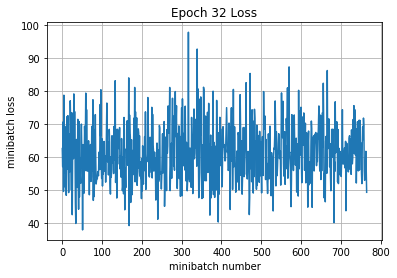

Iteration 24600: with minibatch training loss = 0.86 and accuracy of 0.69
Iteration 24800: with minibatch training loss = 0.896 and accuracy of 0.64
Iteration 25000: with minibatch training loss = 1.14 and accuracy of 0.61
Iteration 25200: with minibatch training loss = 0.952 and accuracy of 0.66
Epoch 33, Overall loss = 0.953 and accuracy of 0.669


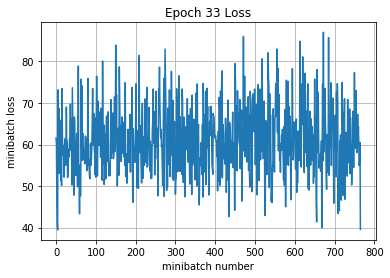

Iteration 25400: with minibatch training loss = 0.959 and accuracy of 0.69
Iteration 25600: with minibatch training loss = 1.12 and accuracy of 0.64
Iteration 25800: with minibatch training loss = 1.01 and accuracy of 0.67
Iteration 26000: with minibatch training loss = 0.979 and accuracy of 0.66
Epoch 34, Overall loss = 0.945 and accuracy of 0.673


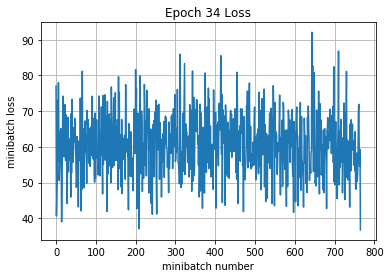

Iteration 26200: with minibatch training loss = 1.09 and accuracy of 0.64
Iteration 26400: with minibatch training loss = 0.898 and accuracy of 0.67
Iteration 26600: with minibatch training loss = 1.06 and accuracy of 0.64
Iteration 26800: with minibatch training loss = 0.776 and accuracy of 0.73
Epoch 35, Overall loss = 0.94 and accuracy of 0.674


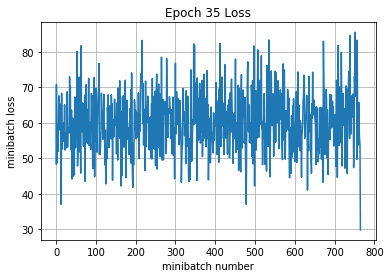

Iteration 27000: with minibatch training loss = 1.13 and accuracy of 0.61
Iteration 27200: with minibatch training loss = 0.684 and accuracy of 0.77
Iteration 27400: with minibatch training loss = 1.13 and accuracy of 0.64
Epoch 36, Overall loss = 0.936 and accuracy of 0.675


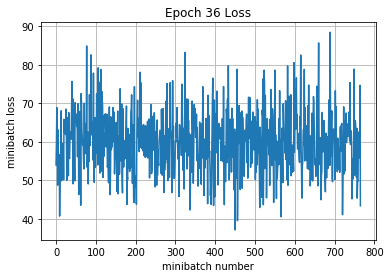

Iteration 27600: with minibatch training loss = 1.06 and accuracy of 0.64
Iteration 27800: with minibatch training loss = 0.781 and accuracy of 0.73
Iteration 28000: with minibatch training loss = 0.948 and accuracy of 0.69
Iteration 28200: with minibatch training loss = 0.893 and accuracy of 0.73
Epoch 37, Overall loss = 0.93 and accuracy of 0.679


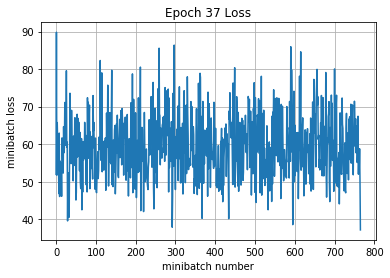

Iteration 28400: with minibatch training loss = 0.818 and accuracy of 0.8
Iteration 28600: with minibatch training loss = 0.942 and accuracy of 0.7
Iteration 28800: with minibatch training loss = 0.887 and accuracy of 0.67
Iteration 29000: with minibatch training loss = 0.694 and accuracy of 0.75
Epoch 38, Overall loss = 0.924 and accuracy of 0.681


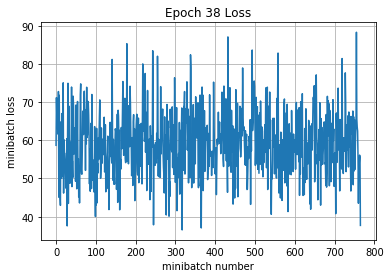

Iteration 29200: with minibatch training loss = 0.64 and accuracy of 0.73
Iteration 29400: with minibatch training loss = 0.968 and accuracy of 0.66
Iteration 29600: with minibatch training loss = 0.845 and accuracy of 0.73
Iteration 29800: with minibatch training loss = 1.02 and accuracy of 0.7
Epoch 39, Overall loss = 0.919 and accuracy of 0.683


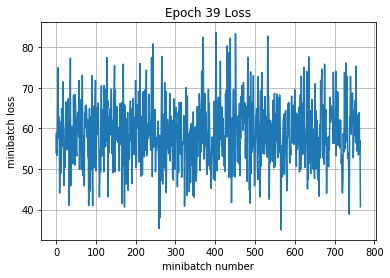

Iteration 30000: with minibatch training loss = 1.04 and accuracy of 0.7
Iteration 30200: with minibatch training loss = 0.921 and accuracy of 0.62
Iteration 30400: with minibatch training loss = 0.935 and accuracy of 0.64
Iteration 30600: with minibatch training loss = 0.798 and accuracy of 0.67
Epoch 40, Overall loss = 0.909 and accuracy of 0.686


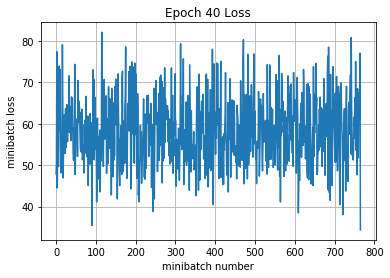

Iteration 30800: with minibatch training loss = 0.923 and accuracy of 0.75
Iteration 31000: with minibatch training loss = 0.94 and accuracy of 0.69
Iteration 31200: with minibatch training loss = 1.23 and accuracy of 0.55
Iteration 31400: with minibatch training loss = 0.927 and accuracy of 0.66
Epoch 41, Overall loss = 0.905 and accuracy of 0.688


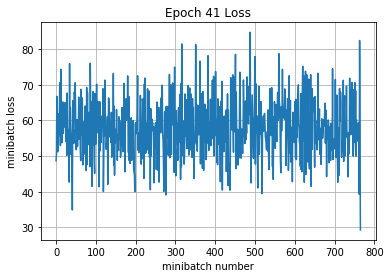

Iteration 31600: with minibatch training loss = 0.777 and accuracy of 0.66
Iteration 31800: with minibatch training loss = 0.875 and accuracy of 0.72
Iteration 32000: with minibatch training loss = 1 and accuracy of 0.69
Epoch 42, Overall loss = 0.902 and accuracy of 0.689


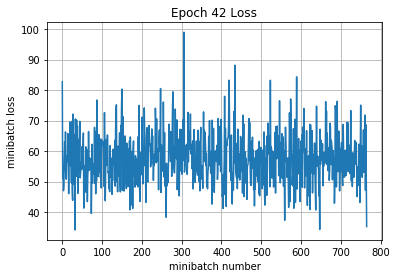

Iteration 32200: with minibatch training loss = 0.904 and accuracy of 0.67
Iteration 32400: with minibatch training loss = 0.712 and accuracy of 0.75
Iteration 32600: with minibatch training loss = 1.08 and accuracy of 0.61
Iteration 32800: with minibatch training loss = 0.937 and accuracy of 0.67
Epoch 43, Overall loss = 0.898 and accuracy of 0.689


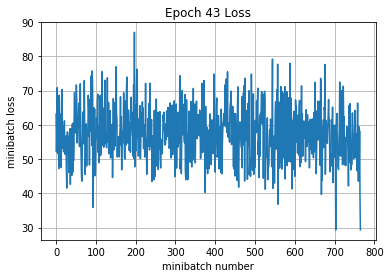

Iteration 33000: with minibatch training loss = 0.827 and accuracy of 0.73
Iteration 33200: with minibatch training loss = 0.829 and accuracy of 0.64
Iteration 33400: with minibatch training loss = 0.636 and accuracy of 0.75
Iteration 33600: with minibatch training loss = 0.879 and accuracy of 0.69
Epoch 44, Overall loss = 0.894 and accuracy of 0.691


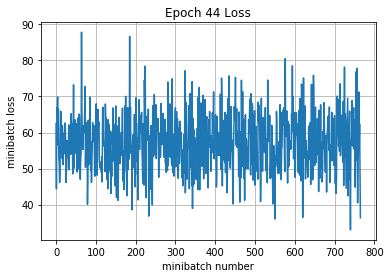

Iteration 33800: with minibatch training loss = 1.06 and accuracy of 0.59
Iteration 34000: with minibatch training loss = 1 and accuracy of 0.62
Iteration 34200: with minibatch training loss = 0.847 and accuracy of 0.69
Iteration 34400: with minibatch training loss = 0.882 and accuracy of 0.73
Epoch 45, Overall loss = 0.892 and accuracy of 0.692


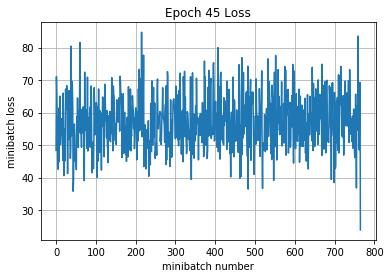

Iteration 34600: with minibatch training loss = 0.736 and accuracy of 0.77
Iteration 34800: with minibatch training loss = 0.935 and accuracy of 0.69
Iteration 35000: with minibatch training loss = 0.974 and accuracy of 0.67
Iteration 35200: with minibatch training loss = 1.03 and accuracy of 0.64
Epoch 46, Overall loss = 0.889 and accuracy of 0.693


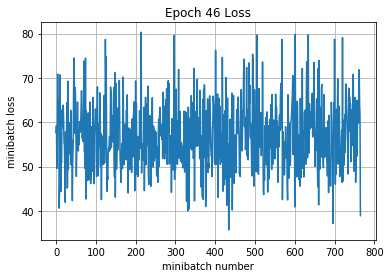

Iteration 35400: with minibatch training loss = 0.973 and accuracy of 0.66
Iteration 35600: with minibatch training loss = 0.838 and accuracy of 0.7
Iteration 35800: with minibatch training loss = 1.07 and accuracy of 0.59
Iteration 36000: with minibatch training loss = 1.03 and accuracy of 0.62
Epoch 47, Overall loss = 0.886 and accuracy of 0.694


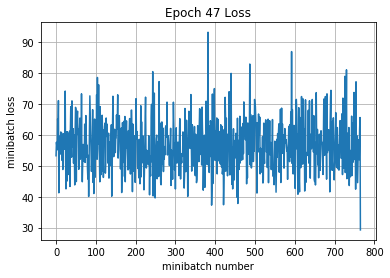

Iteration 36200: with minibatch training loss = 0.952 and accuracy of 0.69
Iteration 36400: with minibatch training loss = 0.971 and accuracy of 0.69
Iteration 36600: with minibatch training loss = 1.02 and accuracy of 0.67
Epoch 48, Overall loss = 0.882 and accuracy of 0.697


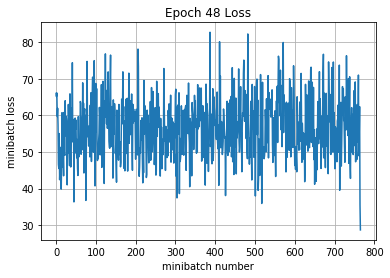

Iteration 36800: with minibatch training loss = 0.727 and accuracy of 0.73
Iteration 37000: with minibatch training loss = 0.78 and accuracy of 0.72
Iteration 37200: with minibatch training loss = 0.783 and accuracy of 0.78
Iteration 37400: with minibatch training loss = 0.689 and accuracy of 0.78
Epoch 49, Overall loss = 0.879 and accuracy of 0.697


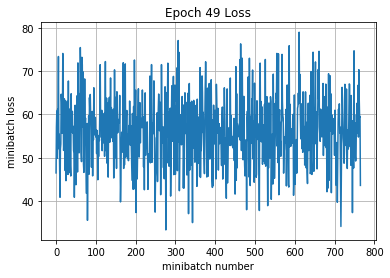

Iteration 37600: with minibatch training loss = 0.73 and accuracy of 0.81
Iteration 37800: with minibatch training loss = 1 and accuracy of 0.64
Iteration 38000: with minibatch training loss = 0.859 and accuracy of 0.72
Iteration 38200: with minibatch training loss = 0.854 and accuracy of 0.67
Epoch 50, Overall loss = 0.877 and accuracy of 0.697


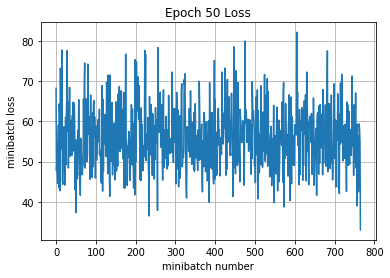

Iteration 38400: with minibatch training loss = 0.908 and accuracy of 0.69
Iteration 38600: with minibatch training loss = 0.835 and accuracy of 0.73
Iteration 38800: with minibatch training loss = 0.861 and accuracy of 0.75
Iteration 39000: with minibatch training loss = 0.955 and accuracy of 0.64
Epoch 51, Overall loss = 0.873 and accuracy of 0.7


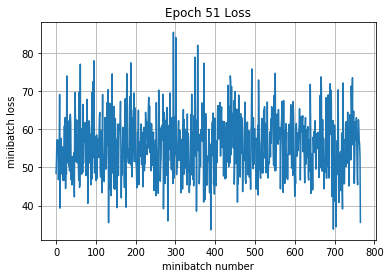

Iteration 39200: with minibatch training loss = 0.779 and accuracy of 0.7
Iteration 39400: with minibatch training loss = 0.921 and accuracy of 0.69
Iteration 39600: with minibatch training loss = 0.786 and accuracy of 0.73
Iteration 39800: with minibatch training loss = 0.952 and accuracy of 0.62
Epoch 52, Overall loss = 0.871 and accuracy of 0.699


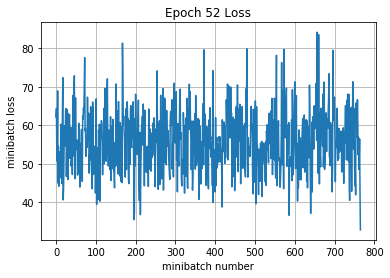

Iteration 40000: with minibatch training loss = 0.914 and accuracy of 0.73
Iteration 40200: with minibatch training loss = 0.909 and accuracy of 0.64
Iteration 40400: with minibatch training loss = 0.947 and accuracy of 0.7
Epoch 53, Overall loss = 0.861 and accuracy of 0.705


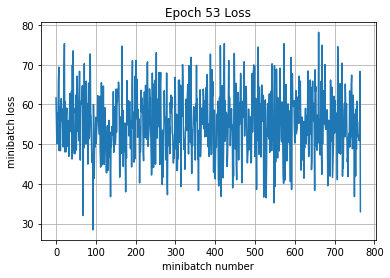

Iteration 40600: with minibatch training loss = 0.827 and accuracy of 0.69
Iteration 40800: with minibatch training loss = 0.84 and accuracy of 0.66
Iteration 41000: with minibatch training loss = 0.704 and accuracy of 0.78
Iteration 41200: with minibatch training loss = 0.973 and accuracy of 0.64
Epoch 54, Overall loss = 0.859 and accuracy of 0.706


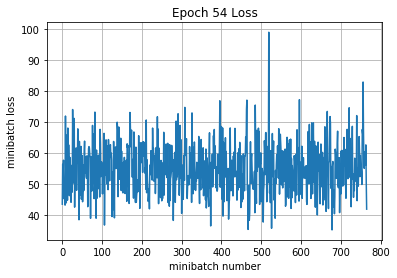

Iteration 41400: with minibatch training loss = 1.1 and accuracy of 0.64
Iteration 41600: with minibatch training loss = 0.772 and accuracy of 0.69
Iteration 41800: with minibatch training loss = 0.82 and accuracy of 0.72
Iteration 42000: with minibatch training loss = 0.843 and accuracy of 0.69
Epoch 55, Overall loss = 0.857 and accuracy of 0.705


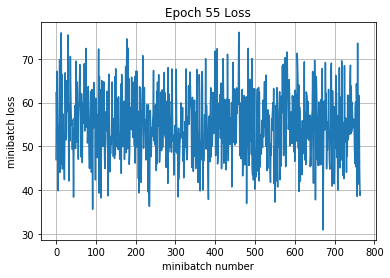

Iteration 42200: with minibatch training loss = 0.97 and accuracy of 0.67
Iteration 42400: with minibatch training loss = 0.781 and accuracy of 0.78
Iteration 42600: with minibatch training loss = 0.787 and accuracy of 0.8
Iteration 42800: with minibatch training loss = 0.851 and accuracy of 0.72
Epoch 56, Overall loss = 0.856 and accuracy of 0.708


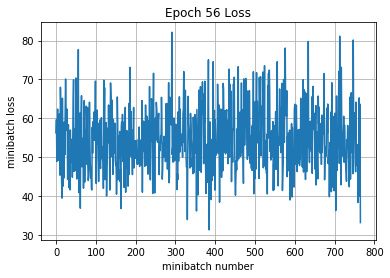

Iteration 43000: with minibatch training loss = 0.813 and accuracy of 0.72
Iteration 43200: with minibatch training loss = 0.901 and accuracy of 0.7
Iteration 43400: with minibatch training loss = 0.773 and accuracy of 0.69
Iteration 43600: with minibatch training loss = 1.01 and accuracy of 0.7
Epoch 57, Overall loss = 0.853 and accuracy of 0.707


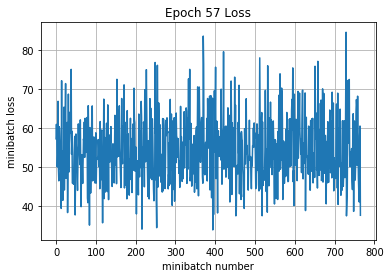

Iteration 43800: with minibatch training loss = 0.886 and accuracy of 0.72
Iteration 44000: with minibatch training loss = 0.956 and accuracy of 0.62
Iteration 44200: with minibatch training loss = 0.841 and accuracy of 0.62
Iteration 44400: with minibatch training loss = 0.792 and accuracy of 0.72
Epoch 58, Overall loss = 0.85 and accuracy of 0.708


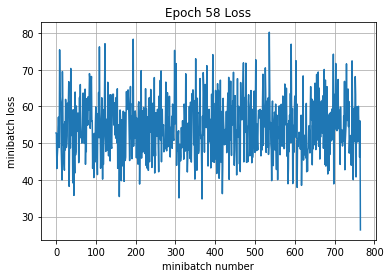

Iteration 44600: with minibatch training loss = 0.839 and accuracy of 0.73
Iteration 44800: with minibatch training loss = 0.983 and accuracy of 0.7
Iteration 45000: with minibatch training loss = 0.81 and accuracy of 0.7
Epoch 59, Overall loss = 0.848 and accuracy of 0.709


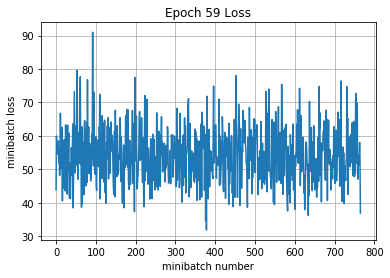

Iteration 45200: with minibatch training loss = 0.709 and accuracy of 0.72
Iteration 45400: with minibatch training loss = 0.965 and accuracy of 0.7
Iteration 45600: with minibatch training loss = 0.938 and accuracy of 0.69
Iteration 45800: with minibatch training loss = 0.877 and accuracy of 0.67
Epoch 60, Overall loss = 0.848 and accuracy of 0.707


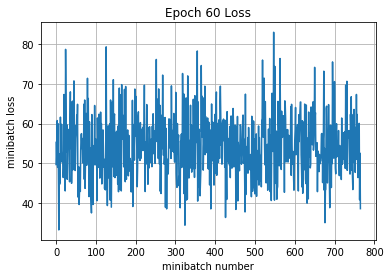

Iteration 46000: with minibatch training loss = 0.897 and accuracy of 0.75
Iteration 46200: with minibatch training loss = 0.715 and accuracy of 0.78
Iteration 46400: with minibatch training loss = 0.76 and accuracy of 0.69
Iteration 46600: with minibatch training loss = 0.735 and accuracy of 0.75
Epoch 61, Overall loss = 0.844 and accuracy of 0.71


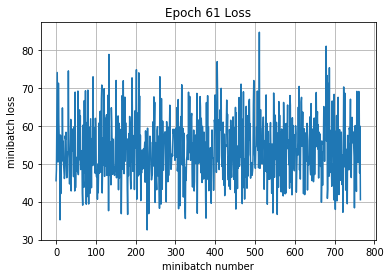

Iteration 46800: with minibatch training loss = 0.986 and accuracy of 0.67
Iteration 47000: with minibatch training loss = 1.06 and accuracy of 0.69
Iteration 47200: with minibatch training loss = 0.953 and accuracy of 0.7
Iteration 47400: with minibatch training loss = 0.837 and accuracy of 0.73
Epoch 62, Overall loss = 0.844 and accuracy of 0.71


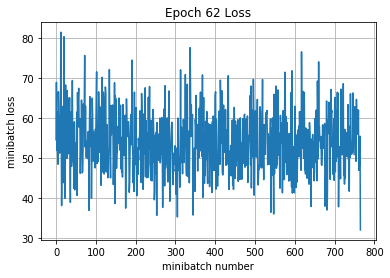

Iteration 47600: with minibatch training loss = 0.718 and accuracy of 0.73
Iteration 47800: with minibatch training loss = 0.881 and accuracy of 0.72
Iteration 48000: with minibatch training loss = 0.82 and accuracy of 0.7
Iteration 48200: with minibatch training loss = 0.991 and accuracy of 0.62
Epoch 63, Overall loss = 0.838 and accuracy of 0.712


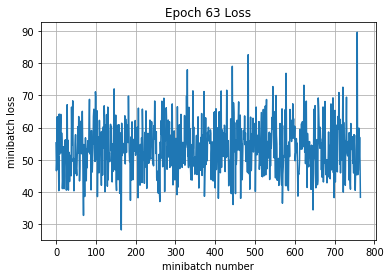

Iteration 48400: with minibatch training loss = 0.774 and accuracy of 0.73
Iteration 48600: with minibatch training loss = 0.898 and accuracy of 0.67
Iteration 48800: with minibatch training loss = 0.951 and accuracy of 0.62
Iteration 49000: with minibatch training loss = 0.91 and accuracy of 0.7
Epoch 64, Overall loss = 0.839 and accuracy of 0.712


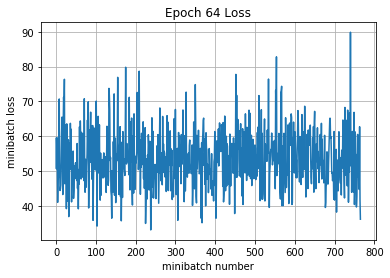

Iteration 49200: with minibatch training loss = 0.799 and accuracy of 0.72
Iteration 49400: with minibatch training loss = 1.15 and accuracy of 0.62
Iteration 49600: with minibatch training loss = 0.842 and accuracy of 0.73
Epoch 65, Overall loss = 0.835 and accuracy of 0.713


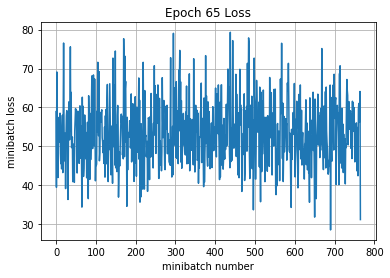

Iteration 49800: with minibatch training loss = 0.761 and accuracy of 0.7
Iteration 50000: with minibatch training loss = 0.793 and accuracy of 0.8
Iteration 50200: with minibatch training loss = 0.782 and accuracy of 0.7
Iteration 50400: with minibatch training loss = 0.781 and accuracy of 0.7
Epoch 66, Overall loss = 0.832 and accuracy of 0.714


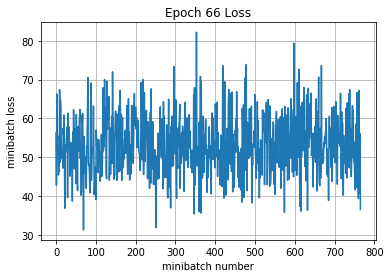

Iteration 50600: with minibatch training loss = 0.879 and accuracy of 0.66
Iteration 50800: with minibatch training loss = 0.688 and accuracy of 0.78
Iteration 51000: with minibatch training loss = 0.9 and accuracy of 0.59
Iteration 51200: with minibatch training loss = 0.875 and accuracy of 0.73
Epoch 67, Overall loss = 0.83 and accuracy of 0.715


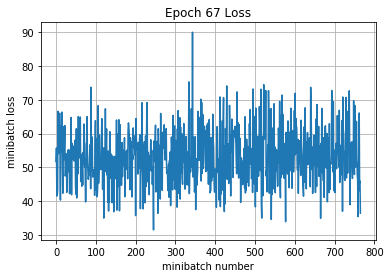

Iteration 51400: with minibatch training loss = 0.804 and accuracy of 0.77
Iteration 51600: with minibatch training loss = 0.863 and accuracy of 0.7
Iteration 51800: with minibatch training loss = 0.768 and accuracy of 0.73
Iteration 52000: with minibatch training loss = 0.783 and accuracy of 0.66
Epoch 68, Overall loss = 0.827 and accuracy of 0.717


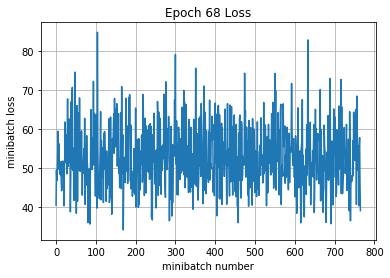

Iteration 52200: with minibatch training loss = 0.671 and accuracy of 0.81
Iteration 52400: with minibatch training loss = 0.781 and accuracy of 0.78
Iteration 52600: with minibatch training loss = 0.7 and accuracy of 0.77
Iteration 52800: with minibatch training loss = 0.812 and accuracy of 0.72
Epoch 69, Overall loss = 0.826 and accuracy of 0.717


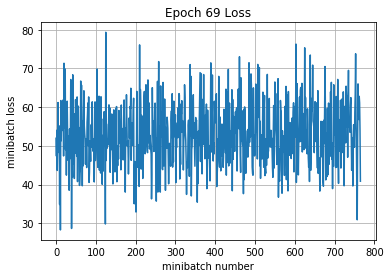

Iteration 53000: with minibatch training loss = 0.727 and accuracy of 0.73
Iteration 53200: with minibatch training loss = 0.918 and accuracy of 0.66
Iteration 53400: with minibatch training loss = 0.762 and accuracy of 0.8
Iteration 53600: with minibatch training loss = 0.941 and accuracy of 0.67
Epoch 70, Overall loss = 0.826 and accuracy of 0.716


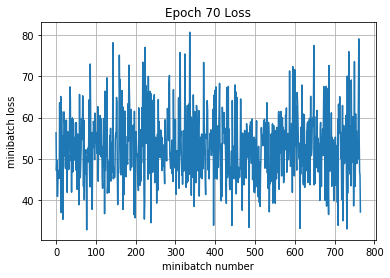

Iteration 53800: with minibatch training loss = 0.91 and accuracy of 0.72
Iteration 54000: with minibatch training loss = 0.878 and accuracy of 0.66
Iteration 54200: with minibatch training loss = 0.781 and accuracy of 0.75
Epoch 71, Overall loss = 0.823 and accuracy of 0.719


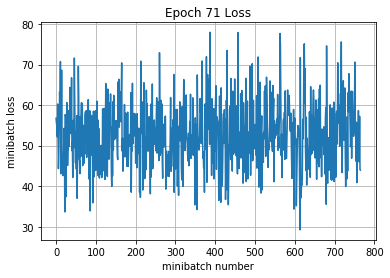

Iteration 54400: with minibatch training loss = 0.965 and accuracy of 0.72
Iteration 54600: with minibatch training loss = 0.866 and accuracy of 0.7
Iteration 54800: with minibatch training loss = 0.831 and accuracy of 0.73
Iteration 55000: with minibatch training loss = 0.863 and accuracy of 0.78
Epoch 72, Overall loss = 0.823 and accuracy of 0.717


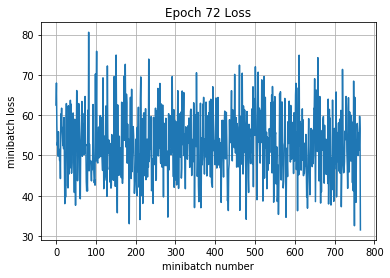

Iteration 55200: with minibatch training loss = 0.846 and accuracy of 0.7
Iteration 55400: with minibatch training loss = 0.826 and accuracy of 0.62
Iteration 55600: with minibatch training loss = 0.726 and accuracy of 0.77
Iteration 55800: with minibatch training loss = 0.93 and accuracy of 0.7
Epoch 73, Overall loss = 0.821 and accuracy of 0.72


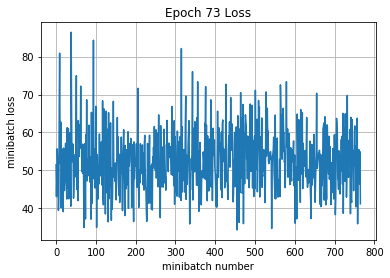

Iteration 56000: with minibatch training loss = 0.772 and accuracy of 0.72
Iteration 56200: with minibatch training loss = 0.749 and accuracy of 0.73
Iteration 56400: with minibatch training loss = 0.795 and accuracy of 0.72
Iteration 56600: with minibatch training loss = 0.809 and accuracy of 0.73
Epoch 74, Overall loss = 0.819 and accuracy of 0.719


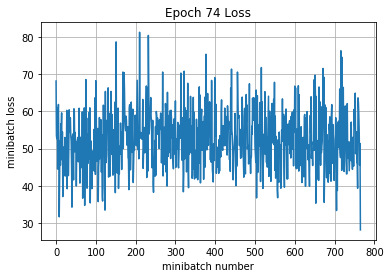

Iteration 56800: with minibatch training loss = 0.846 and accuracy of 0.72
Iteration 57000: with minibatch training loss = 0.882 and accuracy of 0.72
Iteration 57200: with minibatch training loss = 0.993 and accuracy of 0.62
Iteration 57400: with minibatch training loss = 1.05 and accuracy of 0.64
Epoch 75, Overall loss = 0.818 and accuracy of 0.72


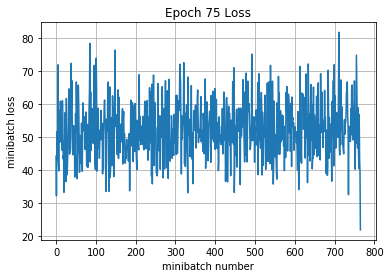

Iteration 57600: with minibatch training loss = 0.969 and accuracy of 0.73
Iteration 57800: with minibatch training loss = 0.795 and accuracy of 0.66
Iteration 58000: with minibatch training loss = 0.681 and accuracy of 0.83
Iteration 58200: with minibatch training loss = 0.754 and accuracy of 0.72
Epoch 76, Overall loss = 0.818 and accuracy of 0.719


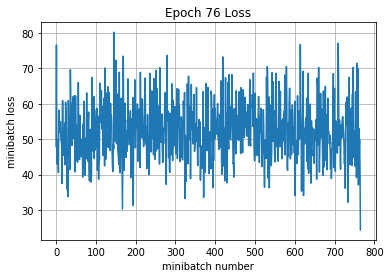

Iteration 58400: with minibatch training loss = 1.14 and accuracy of 0.62
Iteration 58600: with minibatch training loss = 1.01 and accuracy of 0.66
Iteration 58800: with minibatch training loss = 0.688 and accuracy of 0.77
Epoch 77, Overall loss = 0.816 and accuracy of 0.72


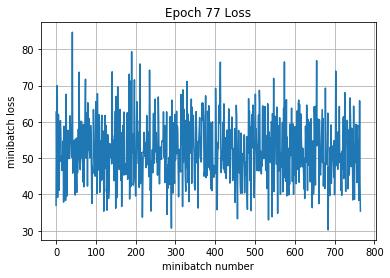

Iteration 59000: with minibatch training loss = 0.949 and accuracy of 0.64
Iteration 59200: with minibatch training loss = 0.872 and accuracy of 0.75
Iteration 59400: with minibatch training loss = 0.934 and accuracy of 0.7
Iteration 59600: with minibatch training loss = 1.13 and accuracy of 0.64
Epoch 78, Overall loss = 0.814 and accuracy of 0.722


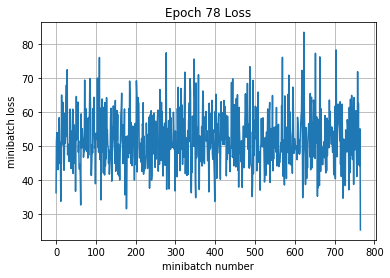

Iteration 59800: with minibatch training loss = 1.22 and accuracy of 0.59
Iteration 60000: with minibatch training loss = 0.671 and accuracy of 0.72
Iteration 60200: with minibatch training loss = 0.725 and accuracy of 0.75
Iteration 60400: with minibatch training loss = 0.703 and accuracy of 0.73
Epoch 79, Overall loss = 0.811 and accuracy of 0.723


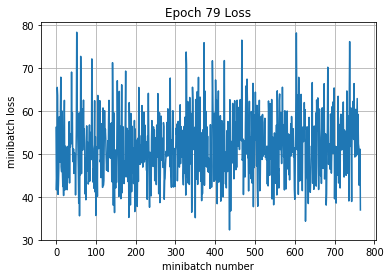

Iteration 60600: with minibatch training loss = 0.692 and accuracy of 0.8
Iteration 60800: with minibatch training loss = 0.635 and accuracy of 0.81
Iteration 61000: with minibatch training loss = 0.822 and accuracy of 0.72
Iteration 61200: with minibatch training loss = 0.699 and accuracy of 0.77
Epoch 80, Overall loss = 0.808 and accuracy of 0.724


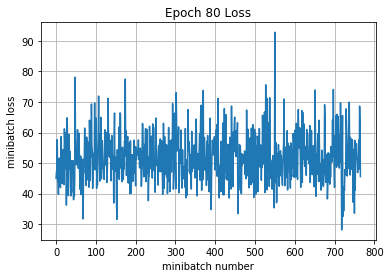

Iteration 61400: with minibatch training loss = 0.679 and accuracy of 0.81
Iteration 61600: with minibatch training loss = 0.678 and accuracy of 0.77
Iteration 61800: with minibatch training loss = 0.943 and accuracy of 0.67
Iteration 62000: with minibatch training loss = 1.01 and accuracy of 0.69
Epoch 81, Overall loss = 0.806 and accuracy of 0.722


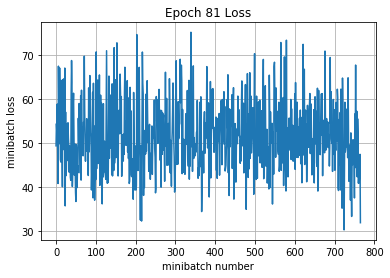

Iteration 62200: with minibatch training loss = 0.741 and accuracy of 0.7
Iteration 62400: with minibatch training loss = 0.824 and accuracy of 0.72
Iteration 62600: with minibatch training loss = 0.788 and accuracy of 0.77
Iteration 62800: with minibatch training loss = 0.829 and accuracy of 0.7
Epoch 82, Overall loss = 0.807 and accuracy of 0.724


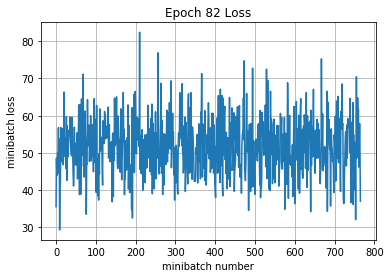

Iteration 63000: with minibatch training loss = 0.49 and accuracy of 0.83
Iteration 63200: with minibatch training loss = 1.04 and accuracy of 0.62
Iteration 63400: with minibatch training loss = 0.934 and accuracy of 0.64
Epoch 83, Overall loss = 0.805 and accuracy of 0.723


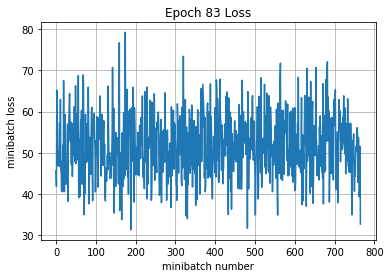

Iteration 63600: with minibatch training loss = 0.856 and accuracy of 0.7
Iteration 63800: with minibatch training loss = 0.835 and accuracy of 0.72
Iteration 64000: with minibatch training loss = 0.747 and accuracy of 0.78
Iteration 64200: with minibatch training loss = 0.511 and accuracy of 0.86
Epoch 84, Overall loss = 0.806 and accuracy of 0.724


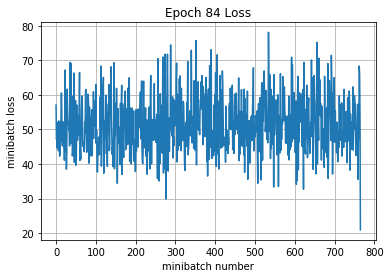

Iteration 64400: with minibatch training loss = 1.04 and accuracy of 0.64
Iteration 64600: with minibatch training loss = 0.642 and accuracy of 0.81
Iteration 64800: with minibatch training loss = 0.927 and accuracy of 0.69
Iteration 65000: with minibatch training loss = 0.54 and accuracy of 0.86
Epoch 85, Overall loss = 0.805 and accuracy of 0.725


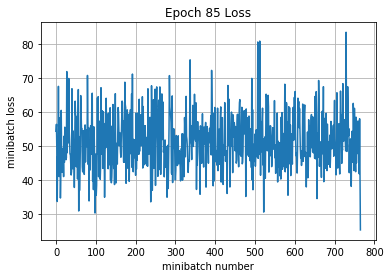

Iteration 65200: with minibatch training loss = 0.742 and accuracy of 0.7
Iteration 65400: with minibatch training loss = 0.619 and accuracy of 0.8
Iteration 65600: with minibatch training loss = 0.867 and accuracy of 0.75
Iteration 65800: with minibatch training loss = 0.884 and accuracy of 0.64
Epoch 86, Overall loss = 0.803 and accuracy of 0.726


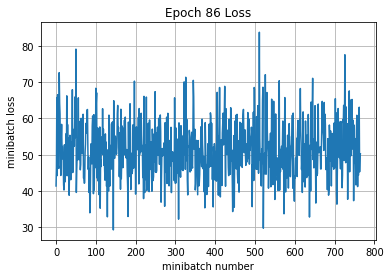

Iteration 66000: with minibatch training loss = 0.82 and accuracy of 0.69
Iteration 66200: with minibatch training loss = 0.633 and accuracy of 0.8
Iteration 66400: with minibatch training loss = 0.729 and accuracy of 0.73
Iteration 66600: with minibatch training loss = 0.753 and accuracy of 0.72
Epoch 87, Overall loss = 0.801 and accuracy of 0.725


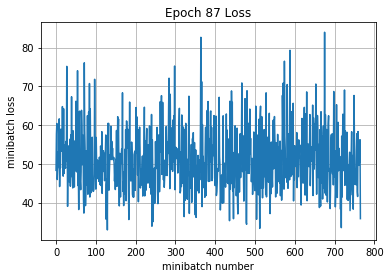

Iteration 66800: with minibatch training loss = 0.93 and accuracy of 0.66
Iteration 67000: with minibatch training loss = 0.707 and accuracy of 0.73
Iteration 67200: with minibatch training loss = 0.801 and accuracy of 0.75
Iteration 67400: with minibatch training loss = 0.591 and accuracy of 0.81
Epoch 88, Overall loss = 0.802 and accuracy of 0.727


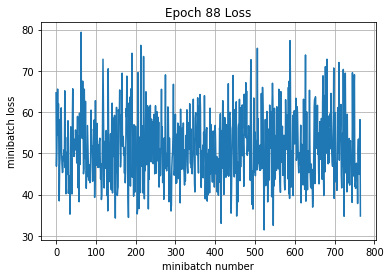

Iteration 67600: with minibatch training loss = 1.01 and accuracy of 0.66
Iteration 67800: with minibatch training loss = 0.847 and accuracy of 0.67
Iteration 68000: with minibatch training loss = 0.73 and accuracy of 0.72
Epoch 89, Overall loss = 0.801 and accuracy of 0.726


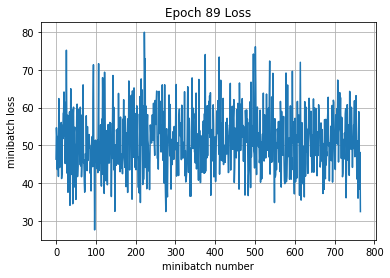

Iteration 68200: with minibatch training loss = 0.657 and accuracy of 0.77
Iteration 68400: with minibatch training loss = 0.744 and accuracy of 0.72
Iteration 68600: with minibatch training loss = 0.708 and accuracy of 0.78
Iteration 68800: with minibatch training loss = 0.874 and accuracy of 0.67
Epoch 90, Overall loss = 0.799 and accuracy of 0.728


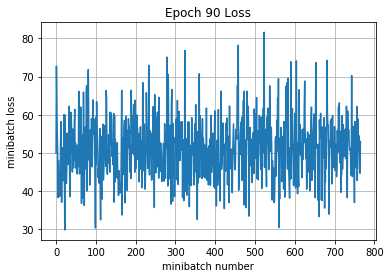

Iteration 69000: with minibatch training loss = 0.73 and accuracy of 0.75
Iteration 69200: with minibatch training loss = 0.831 and accuracy of 0.67
Iteration 69400: with minibatch training loss = 0.899 and accuracy of 0.66
Iteration 69600: with minibatch training loss = 1.07 and accuracy of 0.66
Epoch 91, Overall loss = 0.799 and accuracy of 0.725


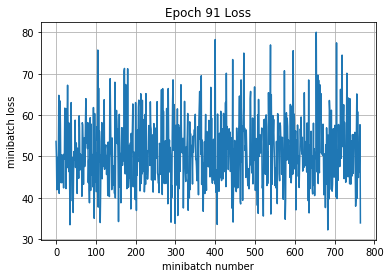

Iteration 69800: with minibatch training loss = 0.86 and accuracy of 0.69
Iteration 70000: with minibatch training loss = 1.02 and accuracy of 0.61
Iteration 70200: with minibatch training loss = 0.711 and accuracy of 0.7
Iteration 70400: with minibatch training loss = 0.646 and accuracy of 0.75
Epoch 92, Overall loss = 0.797 and accuracy of 0.726


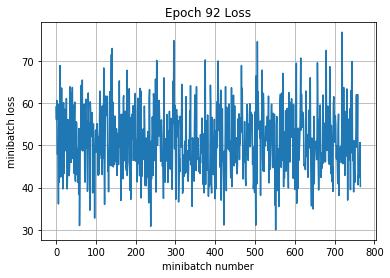

Iteration 70600: with minibatch training loss = 1.01 and accuracy of 0.64
Iteration 70800: with minibatch training loss = 0.894 and accuracy of 0.69
Iteration 71000: with minibatch training loss = 0.602 and accuracy of 0.8
Iteration 71200: with minibatch training loss = 0.828 and accuracy of 0.78
Epoch 93, Overall loss = 0.795 and accuracy of 0.728


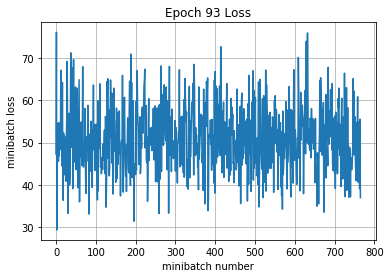

Iteration 71400: with minibatch training loss = 0.945 and accuracy of 0.77
Iteration 71600: with minibatch training loss = 0.744 and accuracy of 0.75
Iteration 71800: with minibatch training loss = 0.855 and accuracy of 0.72
Iteration 72000: with minibatch training loss = 0.573 and accuracy of 0.86
Epoch 94, Overall loss = 0.792 and accuracy of 0.73


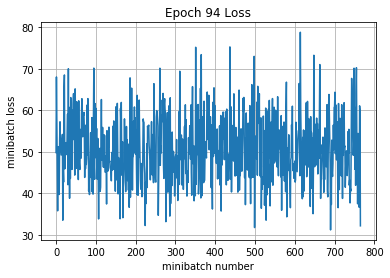

Iteration 72200: with minibatch training loss = 0.694 and accuracy of 0.73
Iteration 72400: with minibatch training loss = 0.77 and accuracy of 0.73
Iteration 72600: with minibatch training loss = 0.783 and accuracy of 0.75
Epoch 95, Overall loss = 0.794 and accuracy of 0.729


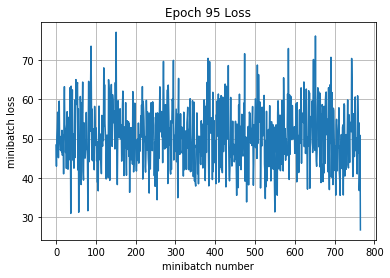

Iteration 72800: with minibatch training loss = 0.792 and accuracy of 0.72
Iteration 73000: with minibatch training loss = 0.712 and accuracy of 0.7
Iteration 73200: with minibatch training loss = 0.622 and accuracy of 0.78
Iteration 73400: with minibatch training loss = 0.645 and accuracy of 0.8
Epoch 96, Overall loss = 0.791 and accuracy of 0.73


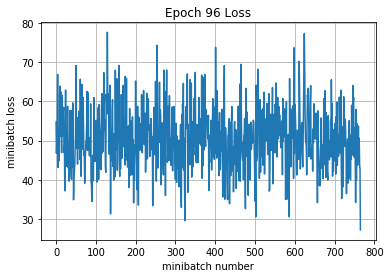

Iteration 73600: with minibatch training loss = 0.585 and accuracy of 0.83
Iteration 73800: with minibatch training loss = 0.813 and accuracy of 0.72
Iteration 74000: with minibatch training loss = 0.823 and accuracy of 0.69
Iteration 74200: with minibatch training loss = 0.892 and accuracy of 0.58
Epoch 97, Overall loss = 0.793 and accuracy of 0.728


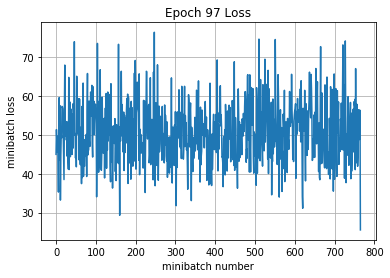

Iteration 74400: with minibatch training loss = 0.836 and accuracy of 0.75
Iteration 74600: with minibatch training loss = 0.753 and accuracy of 0.7
Iteration 74800: with minibatch training loss = 0.662 and accuracy of 0.77
Iteration 75000: with minibatch training loss = 0.83 and accuracy of 0.62
Epoch 98, Overall loss = 0.791 and accuracy of 0.729


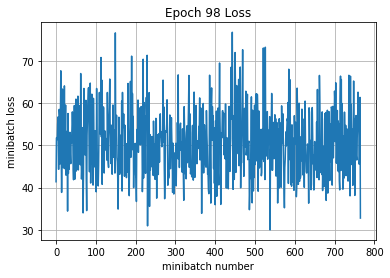

Iteration 75200: with minibatch training loss = 0.737 and accuracy of 0.78
Iteration 75400: with minibatch training loss = 0.715 and accuracy of 0.75
Iteration 75600: with minibatch training loss = 0.845 and accuracy of 0.7
Iteration 75800: with minibatch training loss = 0.733 and accuracy of 0.73
Epoch 99, Overall loss = 0.791 and accuracy of 0.73


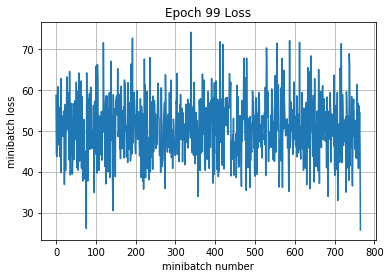

Iteration 76000: with minibatch training loss = 0.885 and accuracy of 0.64
Iteration 76200: with minibatch training loss = 0.728 and accuracy of 0.8
Iteration 76400: with minibatch training loss = 0.665 and accuracy of 0.8
Epoch 100, Overall loss = 0.79 and accuracy of 0.729


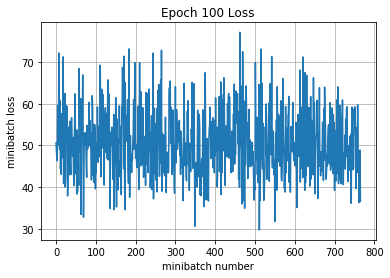

Validation
Epoch 1, Overall loss = 1.08 and accuracy of 0.645


(1.0761675472259522, 0.645)

In [58]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,100,64,200,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [59]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.77 and accuracy of 0.739
Validation
Epoch 1, Overall loss = 1.08 and accuracy of 0.645


(1.0761675567626954, 0.645)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

Just try some initial models w/o digging into the details.
Will further improve this model in the pyTorch notebook.

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [60]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.06 and accuracy of 0.633


(1.0616719648361206, 0.6332)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

1) Learning rate decay
2) GoogleNet approach
3) Shuffle data every epoch
4) Use Elu